#Definitions

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

##Cifar10 Loader

In [3]:
def get_cifar10_loaders(batch_size, partial=None, random=None):
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  
  if random is not None:
    temp = np.random.randint(10, size=len(trainset))
    trainset.targets = [int(label) for label in temp]

  if partial is not None:
    indices = np.arange(0,len(trainset))
    np.random.shuffle(indices)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=2, 
                                              sampler=torch.utils.data.SubsetRandomSampler(indices[:partial]))
  else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  return trainloader, testloader

##Resnet implimation

It is a slight modification of code from:

 https://github.com/hysts/pytorch_wrn/blob/master/wrn.py

In [9]:
!pip install torchinfo

In [15]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary


def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_in')
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.uniform_()
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, drop_rate):
        super(BasicBlock, self).__init__()

        self.drop_rate = drop_rate

        self._preactivate_both = (in_channels != out_channels)

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,  # downsample with first conv
            padding=1,
            bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))

    def forward(self, x):
        if self._preactivate_both:
            x = nn.functional.relu(
                self.bn1(x), inplace=True)  # shortcut after preactivation
            y = self.conv1(x)
        else:
            y = nn.functional.relu(
                self.bn1(x),
                inplace=True)  # preactivation only for residual path
            y = self.conv1(y)
        if self.drop_rate > 0:
            y = nn.functional.dropout(
                y, p=self.drop_rate, training=self.training, inplace=False)

        y = nn.functional.relu(self.bn2(y), inplace=True)
        y = self.conv2(y)
        y += self.shortcut(x)
        return y

class WideResNet(nn.Module):
    def __init__(self, depth = 28, widening_factor = 4, base_channels =  16, n_classes =  10 ,  input_shape = (1, 3, 32, 32), drop_rate = 0):
        super(WideResNet, self).__init__()

        block = BasicBlock
        n_blocks_per_stage = (depth - 4) // 6   # 4 blocks per group as in paper
        assert n_blocks_per_stage * 6 + 4 == depth

        n_channels = [
            base_channels, base_channels * widening_factor,
            base_channels * 2 * widening_factor,
            base_channels * 4 * widening_factor
        ]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=5,    
            stride=1,
            padding=1,
            bias=False)   # 3 changed to 5 for better visualization

        self.stage1 = self._make_stage(
            n_channels[0],
            n_channels[1],
            n_blocks_per_stage,
            block,
            stride=1,
            drop_rate=drop_rate)
        self.stage2 = self._make_stage(
            n_channels[1],
            n_channels[2],
            n_blocks_per_stage,
            block,
            stride=2,
            drop_rate=drop_rate)
        self.stage3 = self._make_stage(
            n_channels[2],
            n_channels[3],
            n_blocks_per_stage,
            block,
            stride=2,
            drop_rate=drop_rate)
        self.bn = nn.BatchNorm2d(n_channels[3])

        # compute conv feature size
        with torch.no_grad():
            self.feature_size = self._forward_conv(
                torch.zeros(*input_shape)).view(-1).shape[0]

        self.fc = nn.Linear(self.feature_size, n_classes)

        # initialize weights
        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, stride,
                    drop_rate):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name,
                    block(
                        in_channels,
                        out_channels,
                        stride=stride,
                        drop_rate=drop_rate))
            else:
                stage.add_module(
                    block_name,
                    block(
                        out_channels,
                        out_channels,
                        stride=1,
                        drop_rate=drop_rate))
        return stage

    def _forward_conv(self, x):
        x = self.conv(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = nn.functional.relu(self.bn(x), inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

#Optimizer

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
def get_training_components(learnable_params, init_lr, step_size=None, gamma=None):
  '''
  Function to prepare components of the training. These are all the same
  throughout the experiments made.
  '''
  # The problem always be a image classification
  criterion = nn.CrossEntropyLoss()
  # Which parameters to be updated depends on if the training is done from scratch
  # or with pre-trained model.
  optimizer = optim.SGD(learnable_params, lr=init_lr, momentum=0.9)
  # Step size depends on the # of epoch
  if step_size is not None:
    scheduler = StepLR(optimizer, step_size, gamma)
    return (criterion, optimizer, scheduler)
  return (criterion, optimizer)

In [7]:
def get_device():
  if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
  else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")

#Trainer

In [25]:
def train(model, criterion, optimizer, epochs, dataloader, device, scheduler=None, verbose=True):
  """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
  """
  loss_history = [] 
  #validloss_history = []
  misalignments = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):    
      
      # Our batch:
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      #inputs = inputs.to(device)
      #labels = labels.to(device)

      # zero the gradients as PyTorch accumulates them
      optimizer.zero_grad()

      # Obtain the scores
      outputs = model.forward(inputs)
      #validoutputs = model.forward(validinputs)
      # Calculate loss
      outputs = outputs.to(device)
      loss = criterion(outputs, labels)
      #valid_loss = criterion(validoutputs, validlabels)
      # Backpropagate
      loss.backward()

      # Update the weights
      optimizer.step()

      loss_history.append(loss.item())
      #validloss_history.append(valid_loss.item())
      
    if verbose: print(f'Epoch {epoch} / {epochs}: avg. train loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history 

#Training

In [19]:
def get_learnable_parameters(model):
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      # print(name)
      params_to_update.append(param)
  return params_to_update

Files already downloaded and verified
Files already downloaded and verified


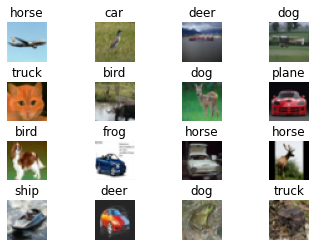

In [24]:
trainloader, _ = get_cifar10_loaders(256,random=True)

dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = dataiter.next()
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

In [16]:
WRN_28_4 = WideResNet(depth=28,widening_factor=4)
device = get_device()
WRN_28_4 = WRN_28_4.to(device)
#simple_cnn.train()
epochs = 1800
learning_rate = 0.005

Cuda (GPU support) is available and enabled!


In [23]:
learnable_parameters = get_learnable_parameters(WRN_28_4)
criterion, optimizer = get_training_components(learnable_parameters, learning_rate)

In [ ]:
loss_history = train(WRN_28_4, criterion, optimizer, epochs, trainloader, device)
PATH = "WRN_28_4.pt"
torch.save(WRN_28_4, PATH)
with open('LossHist.npy', 'wb') as f:
    np.save(f, loss_history)